# 客船沈没事故の生存予測

1.データの前処理

In [69]:
import pandas as pd
import math
from sklearn import tree
from sklearn.model_selection import train_test_split
%matplotlib inline
df = pd.read_csv("datafiles/Survived.csv")
df.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C


In [70]:
df['Survived'].value_counts()
#生存者と死亡の割合が違う→不均衡データという

0    549
1    342
Name: Survived, dtype: int64

#0が生存者で1が死亡だが、0のほうが多いことがわかる

In [71]:
#欠損値の処理
#確認
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

AgeとCabinが多い

In [72]:
df.shape

(891, 11)

In [73]:
#Age列を平均値で穴埋め
df['Age'] = df['Age'].fillna(df['Age'].mean())
#Embarked列を最頻値で穴埋め
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [74]:
#特徴量と正解データを分割
col = ['Pclass','Age','SibSp','Parch','Fare']

x = df[col]

t = df['Survived']

In [75]:
#訓練データとテストデータで分割
x_train,x_test,y_train,y_test = train_test_split(x,t,test_size=0.2,random_state=0)
x_train.shape

(712, 5)

3.モデルの作成と学習

In [76]:
model = tree.DecisionTreeClassifier(max_depth=5,random_state=0,class_weight='balanced')
model.fit(x_train,y_train)#学習

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=0)

4.モデルの評価

In [77]:
#正解率の計算
model.score(X = x_test,y = y_test)

0.7374301675977654

In [78]:
#過学習
#x:特徴量,t:正解データ,depth:木の深さ
def learn(x,t,depth=3):
    x_train,x_test,y_train,y_test = train_test_split(x,t,test_size=0.2,random_state=0)
    
    model = tree.DecisionTreeClassifier(max_depth=depth,random_state=0,class_weight='balanced')
    model.fit(x_train,y_train)
    
    score = model.score(X = x_train,y = y_train)
    score2 = model.score(X = x_test,y = y_test)
    return round(score,3),round(score2,3),model

In [79]:
#木の深さによる正解率の変化を確認
for j in range(1,15):
    train_score,test_score,model = learn(x,t,depth=j)
    
    print( '深さ{}:訓練データの正解率{},テストデータの正解率{}'.format(j,train_score,test_score))

深さ1:訓練データの正解率0.659,テストデータの正解率0.704
深さ2:訓練データの正解率0.699,テストデータの正解率0.732
深さ3:訓練データの正解率0.704,テストデータの正解率0.737
深さ4:訓練データの正解率0.698,テストデータの正解率0.726
深さ5:訓練データの正解率0.722,テストデータの正解率0.737
深さ6:訓練データの正解率0.77,テストデータの正解率0.698
深さ7:訓練データの正解率0.771,テストデータの正解率0.648
深さ8:訓練データの正解率0.781,テストデータの正解率0.631
深さ9:訓練データの正解率0.83,テストデータの正解率0.704
深さ10:訓練データの正解率0.851,テストデータの正解率0.687
深さ11:訓練データの正解率0.878,テストデータの正解率0.676
深さ12:訓練データの正解率0.892,テストデータの正解率0.654
深さ13:訓練データの正解率0.909,テストデータの正解率0.654
深さ14:訓練データの正解率0.92,テストデータの正解率0.654


明らかに深さ6以降のテストデータの正解率が減少している\
モデルのチューニングを見直す必要がある

In [80]:
#欠損値の再埋め込み
#Age列の平均値と中央値の確認
df2 = pd.read_csv("datafiles/Survived.csv")
print(df2['Age'].mean())
print(df2['Age'].median())

29.69911764705882
28.0


#あまり違いがない

In [81]:
#ピポットテーブルによる集計
#小グループ作成の基準となる列を作成
df2.groupby('Survived').mean()['Age']

C:\Users\msy-t\AppData\Local\Temp\ipykernel_676\3097811843.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby('Survived').mean()['Age']


Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

In [82]:
#Pclass列で集計
df2.groupby('Pclass').mean()['Age']

C:\Users\msy-t\AppData\Local\Temp\ipykernel_676\3480431968.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby('Pclass').mean()['Age']


Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

#このような集計をクロス集計といい、pandasのピポットテーブル機能を使えば呼び出せる

In [83]:
#ピポットテーブル機能
pf.pivot_table(df2,index='Survived',columns='Pclass',values='Age')

Pclass,1,2,3
Survived,,,
0,43.695312,33.544444,26.555556
1,35.368197,25.901566,20.646118


In [84]:
#デフォルトで平均値を返すが引数aggfuncを使えば指定可能
pf.pivot_table(df2,index='Survived',columns='Pclass',values='Age',aggfunc=max)

Pclass,1,2,3
Survived,,,
0,71.0,70.0,74.0
1,80.0,62.0,63.0


In [85]:
#Age列の欠損値の行を抜き出す（欠損であれば、True)
is_null = df2['Age'].isnull()

#Pclassに関する埋め込み
df2.loc[(df2['Pclass']==1)&(df2['Survived']==0)&(is_null),'Age']=43
df2.loc[(df2['Pclass']==1)&(df2['Survived']==1)&(is_null),'Age']=35
df2.loc[(df2['Pclass']==2)&(df2['Survived']==0)&(is_null),'Age']=33
df2.loc[(df2['Pclass']==2)&(df2['Survived']==1)&(is_null),'Age']=25
df2.loc[(df2['Pclass']==3)&(df2['Survived']==0)&(is_null),'Age']=26
df2.loc[(df2['Pclass']==3)&(df2['Survived']==1)&(is_null),'Age']=20

In [87]:
col = ['Pclass','Age','SibSp','Parch','Fare']
x = df2[col]
t = df2['Survived']

for j in range(1,15):
    train_score,test_score,model = learn(x,t,depth=j)
    
    print( '深さ{}:訓練データの正解率{},テストデータの正解率{}'.format(j,train_score,test_score))

深さ1:訓練データの正解率0.659,テストデータの正解率0.704
深さ2:訓練データの正解率0.699,テストデータの正解率0.67
深さ3:訓練データの正解率0.722,テストデータの正解率0.715
深さ4:訓練データの正解率0.74,テストデータの正解率0.704
深さ5:訓練データの正解率0.76,テストデータの正解率0.726
深さ6:訓練データの正解率0.794,テストデータの正解率0.793
深さ7:訓練データの正解率0.819,テストデータの正解率0.749
深さ8:訓練データの正解率0.84,テストデータの正解率0.749
深さ9:訓練データの正解率0.885,テストデータの正解率0.743
深さ10:訓練データの正解率0.906,テストデータの正解率0.732
深さ11:訓練データの正解率0.93,テストデータの正解率0.726
深さ12:訓練データの正解率0.947,テストデータの正解率0.737
深さ13:訓練データの正解率0.961,テストデータの正解率0.732
深さ14:訓練データの正解率0.969,テストデータの正解率0.721


In [88]:
#ダミー変数化
sex = df2.groupby('Sex').mean()#df.groupby('基準列').集計関数()
sex['Survived']

C:\Users\msy-t\AppData\Local\Temp\ipykernel_676\717187107.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sex = df2.groupby('Sex').mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

<Axes: xlabel='Sex'>

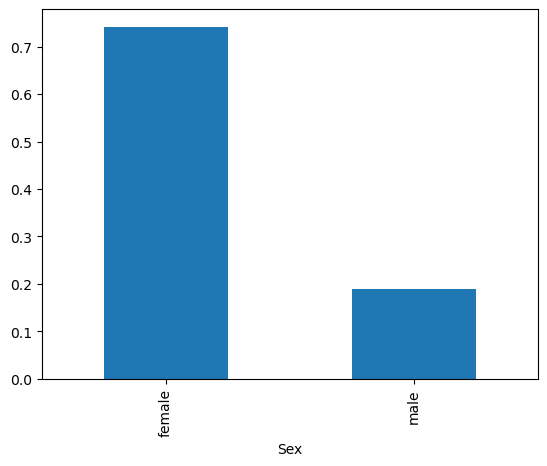

In [89]:
sex['Survived'].plot(kind='bar')

性別も予測性能に影響する

In [90]:
male = pd.get_dummies(df2['Sex'])
male

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [91]:
#get_dummies
male = pd.get_dummies(df2['Sex'],drop_first=True)#drop_firstにTrueを入れると、maleとfemaleの2列のデータフレームを返す。
#今回の場合、一列で十分であるため、Trueにしている。
male

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [92]:
#データフレームを連列
x_temp = pd.concat([x,male],axis=1)#xとmaleを連結
x_temp.head(2)

,Pclass,Age,SibSp,Parch,Fare,male
0,3,22.0,1,0,7.2500,1
1,1,38.0,1,0,71.2833,0


In [96]:
#モデルの再学習
for j in range(1,15):
    train_score,test_score,model = learn(x_temp,t,depth=j)
    
    print( '深さ{}:訓練データの正解率{},テストデータの正解率{}'.format(j,train_score,test_score))

深さ1:訓練データの正解率0.787,テストデータの正解率0.788
深さ2:訓練データの正解率0.792,テストデータの正解率0.782
深さ3:訓練データの正解率0.847,テストデータの正解率0.81
深さ4:訓練データの正解率0.854,テストデータの正解率0.849
深さ5:訓練データの正解率0.865,テストデータの正解率0.86
深さ6:訓練データの正解率0.876,テストデータの正解率0.866
深さ7:訓練データの正解率0.904,テストデータの正解率0.866
深さ8:訓練データの正解率0.912,テストデータの正解率0.894
深さ9:訓練データの正解率0.926,テストデータの正解率0.899
深さ10:訓練データの正解率0.948,テストデータの正解率0.883
深さ11:訓練データの正解率0.956,テストデータの正解率0.832
深さ12:訓練データの正解率0.972,テストデータの正解率0.849
深さ13:訓練データの正解率0.971,テストデータの正解率0.855
深さ14:訓練データの正解率0.979,テストデータの正解率0.844


In [98]:
#モデルを保存
train_score,test_score,model = learn(x_temp,t,depth=5)

import pickle
with open('pklfiles/survived.pkl','wb') as f:
    pickle.dump(model,f)

5.決定木における特徴量の考察

In [99]:
#特徴量重要度
#feature_importances_
model.feature_importances_

array([0.12084767, 0.25107251, 0.06754808, 0.00275855, 0.05145686,
       0.50631633])

In [100]:
#データフレームに変換
pd.DataFrame(model.feature_importances_,index = x_temp.columns)

,0
Pclass,0.120848
Age,0.251073
SibSp,0.067548
Parch,0.002759
Fare,0.051457
male,0.506316


#性別が最も影響を与えることがわかる